# SMArtCARE analysis 

This notebook illustrates the application of the approach on the SMArtCARE dataset (see [Pechmann et al. 2019](https://doi.org/10.1186/s13023-019-0998-4)). It reproduces Figure 3 in the manuscript and the quantitative results stated at the end of Section 4.2.

> **_!!NOTE!!_** This notebook is for illustration of the model code + implementation only. The original SMArtCARE cannot be made available, so the results cannot be reproduced without access to the original data. For a fully reproducible example with a similar data structure, please check the `Simulation.ipynb` notebook with similar analysis on simulated data. 

## Setup

First, we install and load the `LatentDynamics` package, which bundles all functions needed for our proposed approach, and some additional packages for loading data and saving plots. 


In [1]:
cd(@__DIR__)
using Pkg;
Pkg.activate(".")
Pkg.instantiate()

Pkg.add(url="https://github.com/maren-ha/LatentDynamics.jl")

Pkg.status()
cd(@__DIR__)

  Activating project at `~/Desktop/smartcare/ODE-VAE/LatentDynamics/notebooks`
    Updating git-repo `https://github.com/maren-ha/LatentDynamics.jl`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Desktop/smartcare/ODE-VAE/LatentDynamics/notebooks/Project.toml`
  No Changes to `~/Desktop/smartcare/ODE-VAE/LatentDynamics/notebooks/Manifest.toml`


Status `~/Desktop/smartcare/ODE-VAE/LatentDynamics/notebooks/Project.toml`
  [336ed68f] CSV v0.10.11
  [a93c6f00] DataFrames v1.6.1
  [033835bb] JLD2 v0.4.33
  [03719f01] LatentDynamics v0.1.0 `https://github.com/maren-ha/LatentDynamics.jl#main`
  [91a5bcdd] Plots v1.38.17
  [2913bbd2] StatsBase v0.34.0
⌃ [e88e6eb3] Zygote v0.6.59
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [2]:
using LatentDynamics

using CSV 
using DataFrames
using JLD2
using Random
using StatsBase

We save the figures and a table with prediction errors in a `results` directory that we set up below. 

In [3]:
save_dir = "results"
!isdir(save_dir) && mkdir(save_dir)

false

## Specifying the dynamic model

First, we select the dynamic system for the ODE. The available choices include the following functions: 

- `params_fullhomogeneous`: 2-dimensional homogeneous ODE system with full system matrix: 4 parameters 
- `params_driftonly`: 2-dimensional constant ODE system: 2 parameters
- `params_diagonalhomogeneous`: 2-dimensional homogeneous ODE system with diagonal system matrix: 2 parameters
- `params_offdiagonalinhomogeneous`: 2-dimensional inhomogeneous ODE system with system matrix with nonzero off-diagonal elements and zero diagonal: 4 parameters
- `params_diagonalinhomogeneous`: 2-dimensional inhomogeneous ODE system with diagonal system matrix: 4 parameters
- `params_fullinhomogeneous`: 2-dimensional inhomogeneous ODE system with full system matrix: 6 parameters

We choose a homogeneous system with a full system matrix, i.e., with four unknown parameters. The ODE system defined in latent space is thus 

$$ 
\begin{aligned} 
    \frac{\mathrm{d}}{\mathrm{d}t} \begin{pmatrix} \mu_1 \\ \mu_2 \end{pmatrix} (t) 
        &= \begin{pmatrix} \eta_1 & \eta_2 \\ \eta_3 & \eta_4 \end{pmatrix} \begin{pmatrix} \mu_1 \\ \mu_2 \end{pmatrix}(t) 
\end{aligned} 
$$

where $\eta_1, \eta_2, \eta_3, \eta_4$ are the unknown ODE parameters that we infer with an additional neural network from patients' baseline characteristics, to allow for individual-specific trajectories. 

In [4]:
dynamics = params_fullhomogeneous 


params_fullhomogeneous (generic function with 1 method)

## Loading and preprocessing the data

Next, we load and preprocess the data. The data itself cannot be made available due to legal and ethical restrictions, but we will show analysis results in this notebook. 

The processed time-dependent information, baseline variables and observation time points are read from `JLD2` files. 

They are created from the original data frames and applying some preprocessing steps. Additionally, the data is recoded and the test items are transformed to obtain symmetric ranges, which matcht the Gaussian distribution assumption of the VAE model. 

The final time-dependent dataset, `recoded_xs` is represented as a vector of matrices, where each matrix corresponds to the measurements of the time-dependent variables of that patient, i.e., is of shape $(p, T_i)$, where $T_i$ is the number of time points of the $i$-th patient. Since the number of follow-up time points differs between patients, it is not possible to represent the data as a three-dimensional array of shape $(n, p, T)$. Instead, we chose the representation as array of matrices. 

In [6]:
data_path = joinpath(@__DIR__,"datapreprocessing/")

testdata = JLD2.load(joinpath(data_path, "testdata.jld2"), "testdata")
recoded_testdata = JLD2.load(joinpath(data_path, "recoded_testdata.jld2"), "recoded_testdata");

xs, xs_baseline, tvals, ids = testdata.xs, testdata.xs_baseline, testdata.tvals, testdata.ids;
recoded_xs = recoded_testdata.xs;

## Defining the model

Next, we define the behavior of the loss function and the optimization hyperparameters using the `LossArgs` structure. We define additional penalties to regularize the ODE solution estimator appropriately. 

To regularize the inverse-variance weights, we add the log differences between the sample variance of all solutions $\widetilde{\mu}_{i,k}(t, \eta_i), k=0,\dots, T_i$ and the sample variance of all encoded values $\mu_i$, summed across all observed time points with an offset of $0.1$ to avoid values near zero. We also add a regularizing term that penalizes large deviations of the mean as outputted by the encoder and the mean after solving the ODE, to encourage the model to find a latent representation that provides smooth trajectories. 

In [7]:
# define model behaviour 
lossargs = LossArgs(
    skipt0=true, 
    weighting=true, 
    λ_variancepenalty=2.0f0,
    variancepenaltytype = :log_diff,
    variancepenaltyoffset = 0.1f0, 
    λ_μpenalty=1.0f0
) 

LossArgs
  λ_μpenalty: Float32 1.0f0
  λ_variancepenalty: Float32 2.0f0
  variancepenaltytype: Symbol log_diff
  variancepenaltyoffset: Float32 0.1f0
  firstonly: Bool false
  weighting: Bool true
  skipt0: Bool true


Next, we specify the ODE-VAE model structure using the `ModelArgs` structure. This includes the number of input dimensions for the encoder neural network and the neural network that maps baseline variables to ODE parameters, the choice of the dynamic system, some some details about the architecture of the baseline variable neural network. The number of latent dimensions is internally fixed to $2$. 

We then initialize a model using the `odevae` constructor method. 

In [8]:
# define numbers of individuals and variables 
n = length(recoded_xs)

# init model 
modelargs = ModelArgs(p=size(xs[1],1), 
                    q=length(xs_baseline[1]), # zdim=2 default
                    dynamics=dynamics,
                    seed=1234, #1234
                    bottleneck=false, #true, #false for 2 param systems
                    scale_sigmoid=2.0f0, # Struktur des ODE-net: zulässiger Bereich der ODE-Parameter
                    add_diagonal=true # Struktur des ODE-net: Diagonal-Layer am Ende Ja/Nein
)
m = odevae(modelargs)

odevae(20, 24, 2, Chain(Dense(24 => 24, tanh), Dense(24 => 4, #51), Scale(4)), Dense(20 => 20, #53), Dense(20 => 2), Chain(Dense(20 => 2, #54), Scale(2)), Dense(2 => 20, tanh), Dense(20 => 20), Dense(20 => 20), LatentDynamics.params_fullhomogeneous)

## Training the model 

We train the model for 30 training epochs using a learning rate of 0.0005. The initialized model (`m`), the time-dependent and baseline variables (`recoded_xs`, `xs_baseline`), the time points of each patient's follow-up visits, and the training hyperparameters and loss function arguments are all passed to the `train_model!` function.

If desired, the latent trajectories of a selected number of exemplary individuals (`selected_ids`) can be plotted after each epoch to illustrate how training progresses  with `plotting=true`. For this, we need to specify a dedicated wrapper function that will produce the plot as a function of the model `m`. This is shown in the commented-out code below. 

Additionally, if the `verbose` keyword is set to `true`, loss values are displayed after each training epoch. 

In [9]:
Random.seed!(43)
selected_ids = rand(testdata.ids, 12)
 
lr = 0.0005
epochs = 30
train_model!(m, recoded_xs, xs_baseline, tvals, 
    lr, epochs, lossargs,
    verbose=true, 
    plotting=false
)

#=
function make_plot(m::odevae) 
    myplot = plot_selected_ids_piecewise(m, recoded_testdata, selected_ids,
        showOLS=true, 
        layout=(3,4), 
        size=(1000,600), 
        save_plot=false
    )
    return myplot
end
train_model!(m, recoded_xs, xs_baseline, tvals, 
    lr, epochs, lossargs,
    verbose=true, 
    plotting=true, 
    plot_func=make_plot
)
=#

[ Info: 1


mean((loss(data..., m, args = args) for data = trainingdata)) = 48.516674f0


[ Info: 2


mean((loss(data..., m, args = args) for data = trainingdata)) = 42.226315f0


[ Info: 3


mean((loss(data..., m, args = args) for data = trainingdata)) = 39.14735f0


[ Info: 4


mean((loss(data..., m, args = args) for data = trainingdata)) = 35.708447f0


[ Info: 5


mean((loss(data..., m, args = args) for data = trainingdata)) = 31.3169f0


[ Info: 6


mean((loss(data..., m, args = args) for data = trainingdata)) = 29.070776f0


[ Info: 7


mean((loss(data..., m, args = args) for data = trainingdata)) = 27.518623f0


[ Info: 8


mean((loss(data..., m, args = args) for data = trainingdata)) = 26.40576f0


[ Info: 9


mean((loss(data..., m, args = args) for data = trainingdata)) = 25.835106f0


[ Info: 10


mean((loss(data..., m, args = args) for data = trainingdata)) = 25.199848f0


[ Info: 11


mean((loss(data..., m, args = args) for data = trainingdata)) = 24.967676f0


[ Info: 12


mean((loss(data..., m, args = args) for data = trainingdata)) = 24.446373f0


[ Info: 13


mean((loss(data..., m, args = args) for data = trainingdata)) = 24.490807f0


[ Info: 14


mean((loss(data..., m, args = args) for data = trainingdata)) = 24.018238f0


[ Info: 15


mean((loss(data..., m, args = args) for data = trainingdata)) = 23.671324f0


[ Info: 16


mean((loss(data..., m, args = args) for data = trainingdata)) = 23.578205f0


[ Info: 17


mean((loss(data..., m, args = args) for data = trainingdata)) = 23.625925f0


[ Info: 18


mean((loss(data..., m, args = args) for data = trainingdata)) = 22.846651f0


[ Info: 19


mean((loss(data..., m, args = args) for data = trainingdata)) = 23.036934f0


[ Info: 20


mean((loss(data..., m, args = args) for data = trainingdata)) = 22.548615f0


[ Info: 21


mean((loss(data..., m, args = args) for data = trainingdata)) = 22.632801f0


[ Info: 22


mean((loss(data..., m, args = args) for data = trainingdata)) = 22.690205f0


[ Info: 23


mean((loss(data..., m, args = args) for data = trainingdata)) = 22.56522f0


[ Info: 24


mean((loss(data..., m, args = args) for data = trainingdata)) = 22.361357f0


[ Info: 25


mean((loss(data..., m, args = args) for data = trainingdata)) = 22.382418f0


[ Info: 26


mean((loss(data..., m, args = args) for data = trainingdata)) = 22.390495f0


[ Info: 27


mean((loss(data..., m, args = args) for data = trainingdata)) = 22.418612f0


[ Info: 28


mean((loss(data..., m, args = args) for data = trainingdata)) = 22.435875f0


[ Info: 29


mean((loss(data..., m, args = args) for data = trainingdata)) = 22.331476f0


[ Info: 30


mean((loss(data..., m, args = args) for data = trainingdata)) = 21.885948f0


odevae(20, 24, 2, Chain(Dense(24 => 24, tanh), Dense(24 => 4, #51), Scale(4)), Dense(20 => 20, #53), Dense(20 => 2), Chain(Dense(20 => 2, #54), Scale(2)), Dense(2 => 20, tanh), Dense(20 => 20), Dense(20 => 20), LatentDynamics.params_fullhomogeneous)

## Evaluating the model

Next, we evaluate our model, both by visualizing learnt trajectories of exemplary patients and by calculating the error when predicting based on each observed time point the subsequent time point and comparing to the actual value. 

We calculate these predictions both in latent space and also on the level of the reconstructed items, i.e., when decoding the predicted values back to data space using the VAE decoder. 

We compare the predictions of our ODE approach to an adapted regression approach, where at each time point, we fit a line through all previously observed measurements of that patient prior to the time point, shift to the level of the last observed value, to mimick the starting value approach of the ODE, and extrapolate to the subsequent time point. Additionally, we compare the prediction of simpler baseline models, specifically a last-observation-carried-forward (LOCF) approach and an approach where we use the mean of all previously observed values as predictor for the subsequent time point. 
All predictions are evaluated separately for each patient and each latent dimension, and the mean is taken across patients, dimensions and time points. 

First, we show some exemplary plots of fitted latent trajectories:

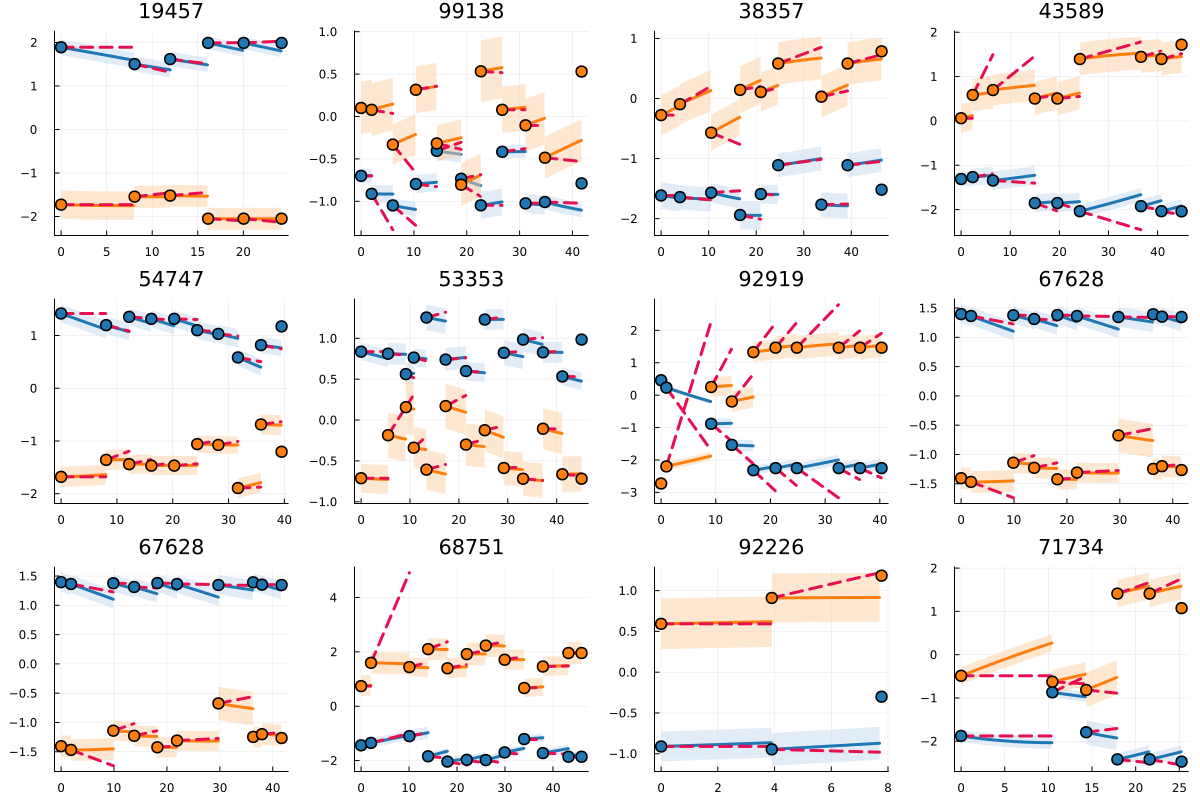

In [10]:
# plotting
panelplot = plot_selected_ids_piecewise(m, recoded_testdata, selected_ids; showOLS=true)

To re-create Figure 3 in the manuscript, we plotted the trajectories of 23 selected patients and additionally showed the piecewise regression fits, to illustrate the different perspective of a function-fitting approach, that is based on previously observed longitudinal data, and our ODE-based approach, where dynamics are specified relative to the current status and parameters are obtained from external information (in our application patients' baseline characteristics). 

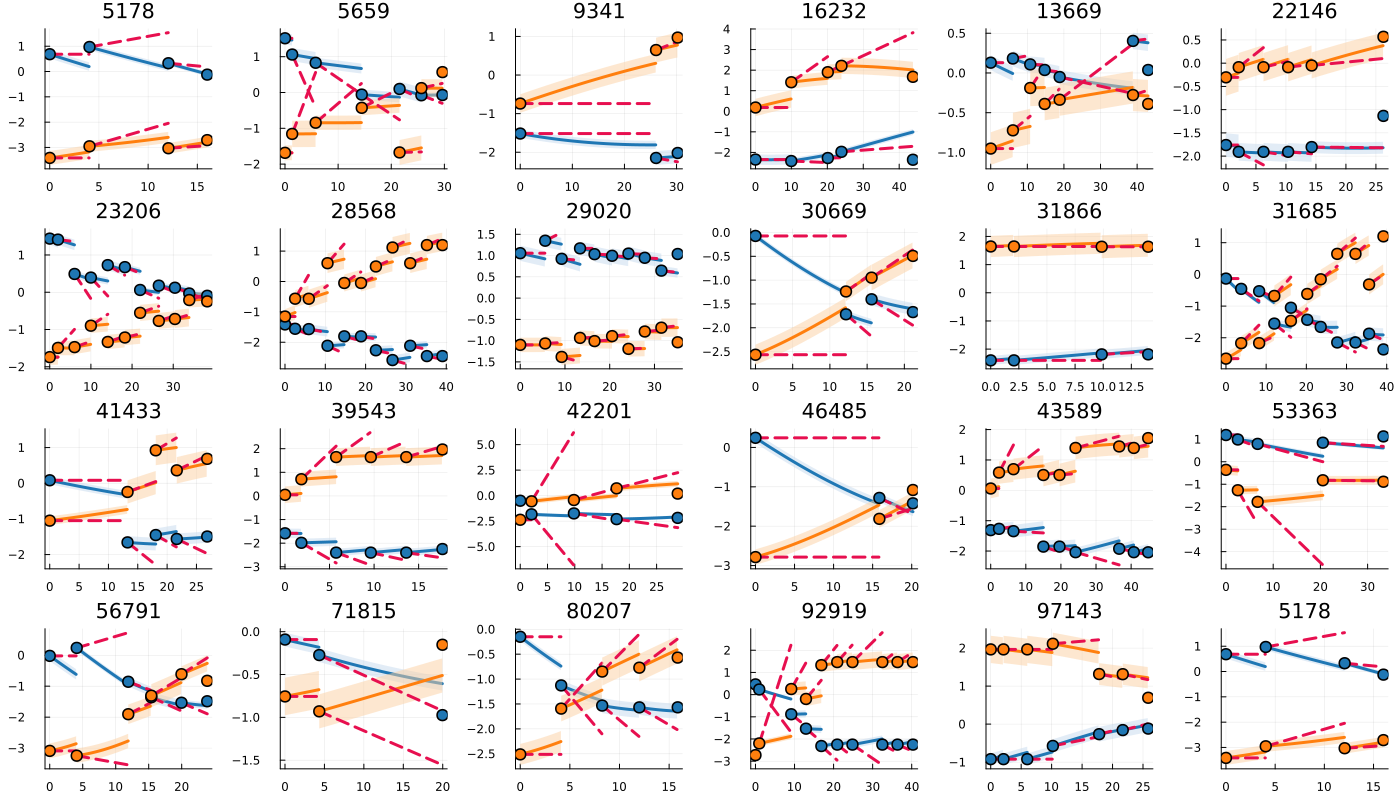

In [11]:
final_selection = [
    5178, 5659, 9341, 16232, 13669, 22146, 
    23206, 28568, 29020, 30669, 31866, 31685, 
    41433, 39543, 42201, 46485, 43589, 53363, 
    56791, 71815, 80207, 92919, 97143, 5178
]

panelplot = plot_selected_ids_piecewise(m, recoded_testdata, final_selection; 
    showOLS=true, 
    layout=(4,6), 
    size=(1400,800), 
    save_plot=true, 
    save_path = joinpath(save_dir, "Figure3_SMArtCARE.pdf")
)

Now, we calculate the prediction errors and create a CSV file that contains the numerical values reported at the end of Section 4.2 in the manuscript. 

In [12]:
# quantitative evaluation 

# measure prediction performance at each time point after the first, for both regression and our approach. 

# in latent space
ODEprederrs, OLSprederrs, locfprederrs, interceptprederrs = eval_prediction(m, recoded_testdata)
# get mean across all individuals
latent_pred_ODE = mean(sum(ODEprederrs)) / length(recoded_testdata.xs)
latent_pred_OLS = mean(sum(OLSprederrs)) / length(recoded_testdata.xs)
latent_pred_LOCF = mean(sum(locfprederrs)) / length(recoded_testdata.xs)
latent_pred_IC = mean(sum(interceptprederrs)) / length(recoded_testdata.xs)

# at the level of the reconstructed data
ODEprederrs, OLSprederrs, locfprederrs, interceptprederrs = eval_reconstructed_prediction(m, recoded_testdata)
# get mean across all individuals
rec_pred_ODE = mean(sum(ODEprederrs)) / length(recoded_testdata.xs)
rec_pred_OLS = mean(sum(OLSprederrs)) / length(recoded_testdata.xs)
rec_pred_LOCF = mean(sum(locfprederrs)) / length(recoded_testdata.xs)
rec_pred_IC = mean(sum(interceptprederrs)) / length(recoded_testdata.xs)

# collect to data frame
prediction_errors = DataFrame(
    model = ["ODE", "OLS", "LOCF"], 
    latent_prediction = [round(latent_pred_ODE, digits=3), round(latent_pred_OLS, digits=3), round(latent_pred_LOCF, digits=3)], 
    reconstructed_prediction = [round(rec_pred_ODE, digits=3), round(rec_pred_OLS, digits=3), round(rec_pred_LOCF, digits=3)]
)
# save to CSV file
CSV.write(joinpath(save_dir,"SMArtCARE_prediction_errors.csv"), string.(prediction_errors))

prediction_errors

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(2 => 20, tanh)  # 60 parameters
│   summary(x) = "2×2 Matrix{Float64}"
└ @ Flux ~/.julia/packages/Flux/n3cOc/src/layers/stateless.jl:60


Row,model,latent_prediction,reconstructed_prediction
,String,Float64,Float32
1,ODE,1.386,5.18
2,OLS,3.522,20.899
3,LOCF,1.597,5.31
